In [2]:
import pandas as pd
import numpy as np
import time                     #python 自带
from astropy.time import Time   #astropy 
from astropy import units as u  
from astropy import constants as const #import constants
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
from astropy.coordinates import Angle
from astropy.coordinates import cartesian_to_spherical
import ligo.skymap.plot

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from moviepy.video.io.bindings import mplfig_to_npimage#动图生成
import moviepy.editor as mpy

In [3]:
def randUnitVec(number):
    phi      = np.random.rand(number,1) * 2 * np.pi  #方位角
    costheta = np.random.rand(number,1) * 2 - 1
    x = np.sqrt(1 - costheta**2) * np.cos(phi)
    y = np.sqrt(1 - costheta**2) * np.sin(phi)
    z = costheta
    r = np.concatenate([x, y, z], axis = 1)
    return r #(x,y,z)

def vecCross(a, b):
    e = np.zeros((3, 3, 3))
    e[0, 1, 2] = e[1, 2, 0] = e[2, 0, 1] = 1
    e[0, 2, 1] = e[2, 1, 0] = e[1, 0, 2] = -1

    c = [np.einsum("i,j,ijk->k", a[i,:],b[i,:], e) for i in range(0, len(a))]
    return np.vstack(c) #(x,y,z)

# def vecDot(a, b):
#     c = [np.einsum("i,j->", a[i,:],b[i,:]) for i in range(0, len(a))]
#     return np.vstack(c) #(x,y,z)

def vecDot(a, b):
    c = [np.inner(a[i],b[i]) for i in range(0, len(a))]
    return np.vstack(c) #(x,y,z)


def cart2spher(r):
    ans   =  cartesian_to_spherical(r[:,0], r[:,1], r[:,2])
    theta = ((np.pi/2 * u.radian - ans[1][0]) ).to('deg').value
    phi   = ans[2][0].to('deg').value
    return theta, phi


def transMat(N_hat):
    zhat  = np.array([[0, 0, 1]])
    Nz    = vecCross(Nhat, zhat)
    NNz = vecCross(Nhat, Nz)
    return np.vstack([Nz, NNz, N_hat])
    


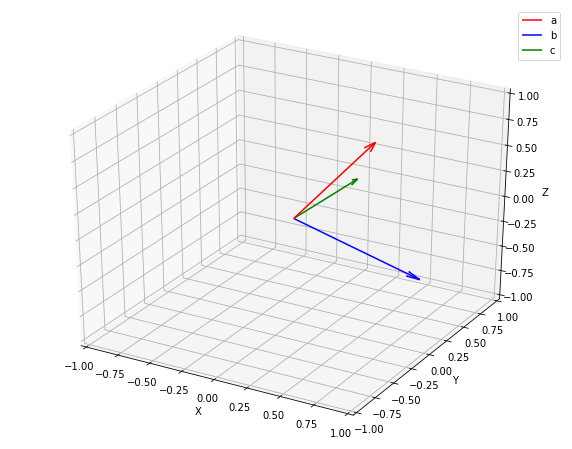

In [4]:
a  = randUnitVec(1)
b  = randUnitVec(1)
c  = vecCross(a,b)


fig = plt.figure(figsize = (10,8))

ax = fig.add_subplot(111, projection='3d')

# ax.view_init(45, 60)
ax.set_zlabel('Z') #坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_xlim(-1,1)#设置刻度
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
# ax.set_axis_off()
ax.quiver(0,0,0, a[:,0], a[:,1], a[:,2], length=1.0,  arrow_length_ratio=0.1, label = 'a', color = 'red')
ax.quiver(0,0,0, b[:,0], b[:,1], b[:,2], length=1.0,  arrow_length_ratio=0.1, label = 'b', color = 'blue' )
ax.quiver(0,0,0, c[:,0], c[:,1], c[:,2], length=1.0,  arrow_length_ratio=0.1, label = 'c', color = 'green' )
plt.legend()

   
plt.show()

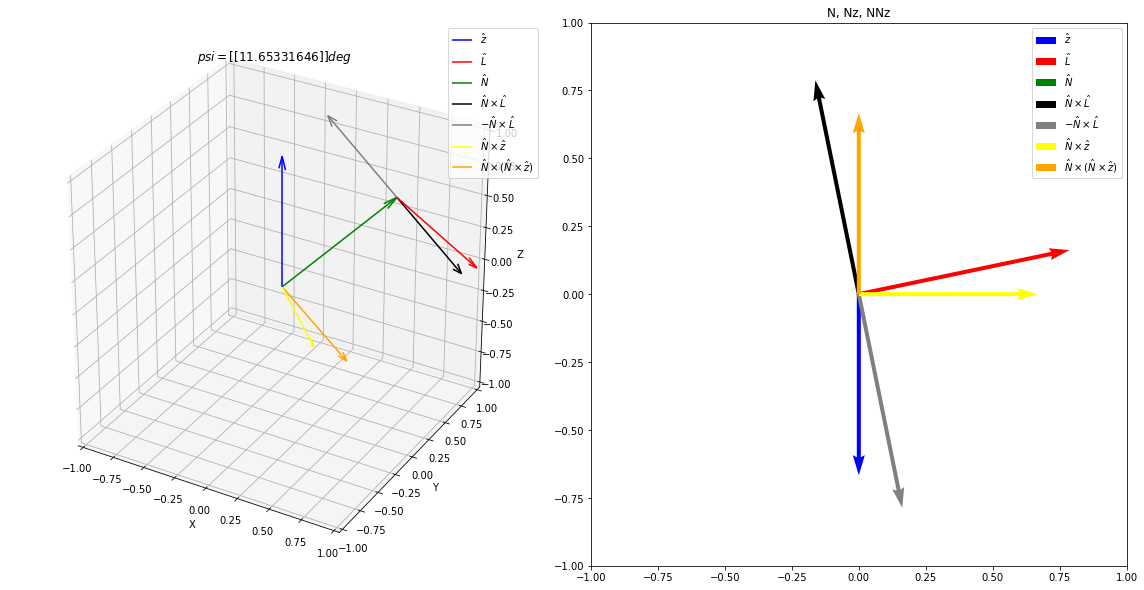

In [6]:
zhat  = np.array([[0, 0, 1]])
xhat  = np.array([[1, 0, 0]])
yhat  = np.array([[0, 1, 0]])
Nhat  = np.array([[np.sqrt(3)/3, np.sqrt(3)/3, np.sqrt(3)/3]])#randUnitVec(1)
Lhat  = randUnitVec(1)
NL = vecCross(Nhat , Lhat)
Nz = vecCross(Nhat, zhat)
NNz = vecCross(Nhat, Nz)

##############################
M = transMat(Nhat)

zhatT = np.inner(M , zhat)
xhatT = np.inner(M , xhat)
yhatT = np.inner(M , yhat)
NhatT = np.inner(M , Nhat)
LhatT = np.inner(M , Lhat)
NLT =  np.inner(M , NL)   
NzT = np.inner(M, Nz)
NNzT = np.inner(M, NNz)
################################


psiValue = np.arctan((vecDot(Lhat, zhat) - vecDot(Lhat, Nhat) * vecDot(zhat, Nhat)) / vecDot(Nhat, vecCross(Lhat,zhat)))
psi = (psiValue * u.radian).to('deg')
psiShow = psi #+ 90 * u.deg
# if ((psi[0][0].value < 0) or (psi[0][0].value > 180)):
#     if psi[0][0].value < 0:
#         psiShow = psi + 180 * u.deg
#     else:
#         psiShow = psi - 180 * u.deg


fig = plt.figure(figsize = (16,16))

ax = fig.add_subplot(221, projection='3d')

# ax.view_init(90, 60)
ax.set_zlabel('Z') #坐标轴
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_xlim(-1,1)#设置刻度
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
# ax.set_axis_off()

ax.quiver(0,0,0, zhat[:,0], zhat[:,1], zhat[:,2], length=1.0,  arrow_length_ratio=0.1, label = '$\hat{z}$', color = 'blue' )

ax.quiver(Nhat[:,0], Nhat[:,1], Nhat[:,2], Lhat[:,0] ,Lhat[:,1] , Lhat[:,2]\
          , length=1.0,  arrow_length_ratio=0.1, label = '$\hat{L}$', color = 'red')
ax.quiver(0,0,0, Nhat[:,0], Nhat[:,1], Nhat[:,2], length=1.0,  arrow_length_ratio=0.1, label = '$\hat{N}$', color = 'green' )
ax.quiver(Nhat[:,0],Nhat[:,1],Nhat[:,2], NL[:,0], NL[:,1], NL[:,2], length=1.0,  arrow_length_ratio=0.1, \
          label = '$\hat{N} \\times \hat{L}$', color = 'black')
ax.quiver(Nhat[:,0],Nhat[:,1],Nhat[:,2], -NL[:,0], -NL[:,1], -NL[:,2], length=1.0,  arrow_length_ratio=0.1, \
          label = '$-\hat{N} \\times \hat{L}$', color = 'grey')
ax.quiver(0,0,0, Nz[:,0], Nz[:,1], Nz[:,2], length=1.0,  arrow_length_ratio=0.1, label = '$\hat{N} \\times \hat{z}$', color = 'yellow' )
ax.quiver(0,0,0, NNz[:,0], NNz[:,1], NNz[:,2], length=1.0,  arrow_length_ratio=0.1, label = '$\hat{N} \\times(\hat{N} \\times \hat{z})$', color = 'orange' )

plt.title("$psi = %s$"%(psiShow))
plt.legend()


ax = fig.add_subplot(222)


ax.quiver(0,0, zhatT[0,0], zhatT[1,0], label = '$\hat{z}$', color = 'blue', angles='xy', scale_units='xy', scale=1 )
ax.quiver(0,0, LhatT[0,0], LhatT[1,0], label = '$\hat{L}$', color = 'red', angles='xy', scale_units='xy', scale=1 )
ax.quiver(0,0, NhatT[0,0], NhatT[1,0], label = '$\hat{N}$', color = 'green', angles='xy', scale_units='xy', scale=1 )
ax.quiver(0,0, NLT[0,0], NLT[1,0], label = '$\hat{N} \\times \hat{L}$', color = 'black', angles='xy', scale_units='xy', scale=1 )
ax.quiver(0,0, -NLT[0,0], -NLT[1,0], label = '$-\hat{N} \\times \hat{L}$', color = 'grey', angles='xy', scale_units='xy', scale=1 )
ax.quiver(0,0, NzT[0,0], NzT[1,0], label = '$\hat{N} \\times \hat{z}$', color = 'yellow', angles='xy', scale_units='xy', scale=1 )
ax.quiver(0,0, NNzT[0,0], NNzT[1,0], label = '$\hat{N} \\times(\hat{N} \\times \hat{z})$', color = 'orange', angles='xy', scale_units='xy', scale=1 )

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("N, Nz, NNz")
plt.legend()


plt.tight_layout()
plt.show()